| Technological Institute of the Philippines | Quezon City - Computer Engineering |
| ------------------------------------------ | ------------------------------------ |
| **Course Code:**                           | CPE 313                             |
| **Course Title:**                          | Advanced Machine Learning and Deep Learning |
| **2nd Semester**                           | AY 2024-2025                         |
| **Assignment 4.1**                       | Mood Detection with OpenCV                   |
| **Name:**                                  | Sumilang, Kenneth                    |
| **Section:**                               | CPE31S3                              ||
| **Instructor:**                            | Dr. Alonica Villanueva               |


# 📌 Objective Overview


This notebook demonstrates a computer vision system capable of:

* Recognizing whether the detected face is yours or not.

* Classifying your mood into one of four categories: Happy, Sad, Angry, Confused.

* Performing testing and evaluation to show detection and classification accuracy.



**Objective**: Create two datasets

* FaceID dataset -> My Face, Other Face
* Mood Dataset -> My Face - > Happy, Sad, Angry, Confused



### Creating My Mood Dataset

In [2]:
# CaptureMood.py
import cv2
import os

# === CONFIG ===
moods = ["Happy", "Sad", "Angry", "Confused"]
base_dir = "captured_moods"   # Folder to save images
num_images_per_mood = 50      # Adjust as needed
capture_delay = 3             # Seconds between captures

# === CREATE FOLDERS ===
for mood in moods:
    os.makedirs(os.path.join(base_dir, mood), exist_ok=True)

# === INIT WEBCAM ===
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

print("\n📸 Mood Capture Started!")
print("Press [SPACE] to capture an image, [ESC] to quit.\n")

for mood in moods:
    print(f"➡️ Capturing images for mood: {mood}")
    print("Position your face and press SPACE to capture...")

    saved = 0
    while saved < num_images_per_mood:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break

        cv2.putText(frame, f"Mood: {mood} ({saved}/{num_images_per_mood})",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
        cv2.imshow("Mood Capture", frame)

        key = cv2.waitKey(1)

        if key == 27:  # ESC key to exit
            print("❌ Exiting early...")
            cap.release()
            cv2.destroyAllWindows()
            exit()

        if key == 32:  # SPACE to save frame
            file_path = os.path.join(base_dir, mood, f"{mood.lower()}_{saved}.jpg")
            cv2.imwrite(file_path, frame)
            saved += 1

    print(f"✅ Finished capturing for mood: {mood}\n")

print("🎉 Done capturing all moods.")
cap.release()
cv2.destroyAllWindows()



📸 Mood Capture Started!
Press [SPACE] to capture an image, [ESC] to quit.

➡️ Capturing images for mood: Happy
Position your face and press SPACE to capture...
✅ Finished capturing for mood: Happy

➡️ Capturing images for mood: Sad
Position your face and press SPACE to capture...
✅ Finished capturing for mood: Sad

➡️ Capturing images for mood: Angry
Position your face and press SPACE to capture...
✅ Finished capturing for mood: Angry

➡️ Capturing images for mood: Confused
Position your face and press SPACE to capture...
✅ Finished capturing for mood: Confused

🎉 Done capturing all moods.


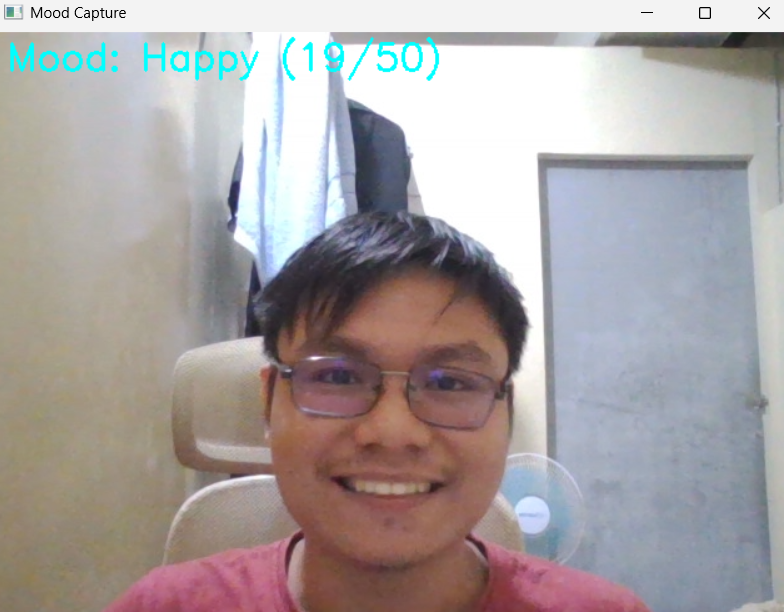

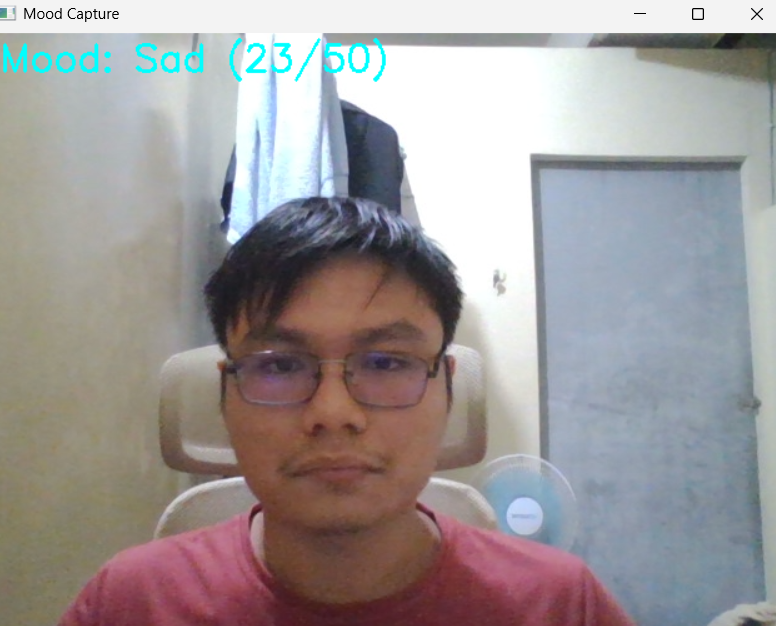

### Get annotated Dataset from RoboFlow


In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="NLNblPQHz5WGmGHG9nrw")
project = rf.workspace("proj-pd-xd").project("mood-detection-5jdqf")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Mood-Detection-3 in yolov8:: 100%|██████████| 968/968 [00:00<00:00, 2190.90it/s]


In [2]:
dataset = version.download("yolov8")


In [ ]:
print(dataset.location)

c:\Users\KEN\Desktop\DSI\Mood Detection Activity\Mood-Detection-3


### Dataset is actually imbalanced. Let's resplit them

In [4]:
import os
import random
import shutil

# Set paths
base_path = "Mood-Detection-3"  # change if different
train_dir = os.path.join(base_path, "train", "images")
valid_dir = os.path.join(base_path, "valid", "images")
test_dir = os.path.join(base_path, "test", "images")

# Combine all image paths
all_images = [f for f in os.listdir(train_dir)] + \
             [f for f in os.listdir(valid_dir)] + \
             [f for f in os.listdir(test_dir)]
random.shuffle(all_images)

# Resplit
n_total = len(all_images)
n_train = int(n_total * 0.7)
n_valid = int(n_total * 0.2)
n_test = n_total - n_train - n_valid

new_splits = {
    "train": all_images[:n_train],
    "valid": all_images[n_train:n_train + n_valid],
    "test": all_images[n_train + n_valid:]
}

# Move files (images and corresponding labels)
for split, files in new_splits.items():
    for fname in files:
        # move image
        for folder in ["train", "valid", "test"]:
            src_img = os.path.join(base_path, folder, "images", fname)
            if os.path.exists(src_img):
                break
        dst_img = os.path.join(base_path, split, "images", fname)
        os.makedirs(os.path.dirname(dst_img), exist_ok=True)
        shutil.move(src_img, dst_img)

        # move label
        label_name = fname.replace(".jpg", ".txt").replace(".png", ".txt")
        for folder in ["train", "valid", "test"]:
            src_lbl = os.path.join(base_path, folder, "labels", label_name)
            if os.path.exists(src_lbl):
                break
        dst_lbl = os.path.join(base_path, split, "labels", label_name)
        os.makedirs(os.path.dirname(dst_lbl), exist_ok=True)
        shutil.move(src_lbl, dst_lbl)

print("✅ Dataset resplit into 70/20/10.")


✅ Dataset resplit into 70/20/10.


Double check

In [5]:
import os

# Set your base dataset path
base_path = "Mood-detection-3"  # or whatever your folder is called

splits = ["train", "valid", "test"]
for split in splits:
    img_dir = os.path.join(base_path, split, "images")
    label_dir = os.path.join(base_path, split, "labels")

    # Count image and label files
    img_count = len([f for f in os.listdir(img_dir) if f.endswith((".jpg", ".jpeg", ".png"))])
    label_count = len([f for f in os.listdir(label_dir) if f.endswith(".txt")])

    print(f"{split.upper():<6} ➤ Images: {img_count:3} | Labels: {label_count:3}")


TRAIN  ➤ Images: 334 | Labels: 334
VALID  ➤ Images:  95 | Labels:  95
TEST   ➤ Images:  49 | Labels:  49


### Training (Mood Detection)

In [6]:
from ultralytics import YOLO

# Load a YOLOv8 model (smallest for quick training)
model = YOLO('yolov8n.pt')

# Train on the Roboflow-exported dataset
model.train(data=f"{dataset.location}/data.yaml", epochs=50, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.107 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.75  Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\KEN\Desktop\DSI\Mood Detection Activity\Mood-Detection-3/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False

train: Scanning C:\Users\KEN\Desktop\DSI\Mood Detection Activity\Mood-Detection-3\train\labels... 334 images, 0 backgrounds, 0 corrupt: 100%|██████████| 334/334 [00:00<00:00, 750.81it/s]

train: New cache created: C:\Users\KEN\Desktop\DSI\Mood Detection Activity\Mood-Detection-3\train\labels.cache



val: Scanning C:\Users\KEN\Desktop\DSI\Mood Detection Activity\Mood-Detection-3\valid\labels... 95 images, 0 backgrounds, 0 corrupt: 100%|██████████| 95/95 [00:00<00:00, 455.11it/s]

val: New cache created: C:\Users\KEN\Desktop\DSI\Mood Detection Activity\Mood-Detection-3\valid\labels.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       2.2G      1.623       3.55      1.838         30        640: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

                   all         95         95     0.0034          1      0.342      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.07G      1.256      2.694      1.458         20        640: 100%|██████████| 21/21 [00:02<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

                   all         95         95       0.62      0.399       0.41      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.07G      1.284      2.463      1.437         30        640: 100%|██████████| 21/21 [00:02<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.78it/s]

                   all         95         95      0.479      0.331      0.505      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.07G      1.249       2.36      1.408         38        640: 100%|██████████| 21/21 [00:02<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

                   all         95         95      0.517      0.316      0.427      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.07G      1.283      2.181      1.385         27        640: 100%|██████████| 21/21 [00:02<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]

                   all         95         95      0.521      0.666      0.691      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.07G      1.255      2.129      1.385         31        640: 100%|██████████| 21/21 [00:02<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         95         95      0.173       0.48      0.286      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.07G      1.233      2.008      1.334         24        640: 100%|██████████| 21/21 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

                   all         95         95      0.467      0.815      0.795      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.07G      1.254      1.931      1.364         25        640: 100%|██████████| 21/21 [00:02<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]

                   all         95         95      0.608      0.654       0.74       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.07G      1.247      1.815      1.343         35        640: 100%|██████████| 21/21 [00:02<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]


                   all         95         95      0.856       0.25      0.318      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.07G      1.193       1.77      1.303         35        640: 100%|██████████| 21/21 [00:02<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         95         95      0.653       0.89      0.872      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.07G        1.2      1.659      1.316         30        640: 100%|██████████| 21/21 [00:02<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         95         95      0.612      0.504      0.745      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.07G      1.189      1.547      1.266         31        640: 100%|██████████| 21/21 [00:02<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

                   all         95         95      0.847      0.685      0.736      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.07G      1.182      1.492      1.276         29        640: 100%|██████████| 21/21 [00:02<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

                   all         95         95      0.772      0.819      0.853      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.07G      1.202      1.429      1.291         28        640: 100%|██████████| 21/21 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         95         95      0.822      0.921      0.893      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.07G      1.196      1.379      1.284         26        640: 100%|██████████| 21/21 [00:02<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]

                   all         95         95      0.956      0.983      0.994      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.07G      1.177      1.395      1.295         22        640: 100%|██████████| 21/21 [00:02<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         95         95      0.978      0.996      0.995      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.07G      1.148      1.308      1.271         33        640: 100%|██████████| 21/21 [00:02<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         95         95      0.988          1      0.995      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.07G        1.2      1.284      1.285         27        640: 100%|██████████| 21/21 [00:02<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]

                   all         95         95       0.97      0.986      0.995      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.07G      1.136      1.235       1.26         29        640: 100%|██████████| 21/21 [00:02<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all         95         95      0.842      0.955      0.932      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.07G      1.177      1.196      1.237         36        640: 100%|██████████| 21/21 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

                   all         95         95      0.921      0.969      0.994      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.07G      1.135      1.158      1.223         25        640: 100%|██████████| 21/21 [00:02<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]

                   all         95         95      0.853          1      0.991      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.07G      1.128      1.138      1.234         33        640: 100%|██████████| 21/21 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

                   all         95         95      0.945      0.946      0.995      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.07G      1.125      1.172      1.254         31        640: 100%|██████████| 21/21 [00:02<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]

                   all         95         95      0.897      0.931      0.987      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.07G       1.11      1.134      1.233         29        640: 100%|██████████| 21/21 [00:02<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         95         95      0.989          1      0.995      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.07G      1.124       1.14      1.234         21        640: 100%|██████████| 21/21 [00:02<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

                   all         95         95      0.986          1      0.995      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.07G      1.118      1.085      1.227         31        640: 100%|██████████| 21/21 [00:02<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

                   all         95         95      0.984          1      0.995      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.07G      1.074      1.069      1.223         29        640: 100%|██████████| 21/21 [00:02<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]

                   all         95         95      0.994          1      0.995      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.07G      1.118       1.04      1.242         28        640: 100%|██████████| 21/21 [00:02<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]

                   all         95         95      0.987      0.999      0.995      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.07G      1.084      1.067      1.217         29        640: 100%|██████████| 21/21 [00:02<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

                   all         95         95      0.987      0.999      0.995      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.07G      1.065      1.027      1.206         30        640: 100%|██████████| 21/21 [00:02<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]

                   all         95         95      0.993      0.974      0.995      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.07G      1.072     0.9986       1.22         22        640: 100%|██████████| 21/21 [00:02<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

                   all         95         95      0.992          1      0.995      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.07G      1.086      0.986      1.223         26        640: 100%|██████████| 21/21 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]

                   all         95         95       0.99          1      0.995      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.07G      1.059      0.926      1.186         36        640: 100%|██████████| 21/21 [00:02<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

                   all         95         95      0.983          1      0.995      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.07G      1.043     0.9465      1.203         27        640: 100%|██████████| 21/21 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]

                   all         95         95      0.986      0.998      0.995      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.07G      1.015     0.9199      1.187         30        640: 100%|██████████| 21/21 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]

                   all         95         95      0.989          1      0.995      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.07G      1.078      0.913      1.193         21        640: 100%|██████████| 21/21 [00:02<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.88it/s]

                   all         95         95      0.991          1      0.995      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.07G      1.045     0.9087      1.185         31        640: 100%|██████████| 21/21 [00:02<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

                   all         95         95       0.99          1      0.995      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.07G       1.04     0.8941      1.204         23        640: 100%|██████████| 21/21 [00:02<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]

                   all         95         95      0.983      0.989      0.995      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.07G      1.001     0.8758      1.179         27        640: 100%|██████████| 21/21 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         95         95      0.974      0.994      0.995      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.07G      1.029      0.881      1.184         25        640: 100%|██████████| 21/21 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]

                   all         95         95      0.991          1      0.995      0.702


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.16G      1.043     0.7763      1.288         14        640: 100%|██████████| 21/21 [00:03<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]


                   all         95         95      0.991          1      0.995        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.07G      1.032     0.7703      1.274         14        640: 100%|██████████| 21/21 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]

                   all         95         95      0.993          1      0.995       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.07G      1.018     0.7556      1.235         14        640: 100%|██████████| 21/21 [00:02<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

                   all         95         95      0.989          1      0.995      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.07G     0.9856      0.734      1.226         14        640: 100%|██████████| 21/21 [00:02<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

                   all         95         95      0.992          1      0.995      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.07G     0.9949      0.727      1.262         14        640: 100%|██████████| 21/21 [00:02<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

                   all         95         95      0.991          1      0.995      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.07G     0.9789     0.6975      1.241         14        640: 100%|██████████| 21/21 [00:02<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]

                   all         95         95      0.993          1      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.07G     0.9575     0.6905       1.24         14        640: 100%|██████████| 21/21 [00:02<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         95         95      0.993          1      0.995      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.07G     0.9468     0.6777      1.198         14        640: 100%|██████████| 21/21 [00:02<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]

                   all         95         95      0.992          1      0.995      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.07G     0.9488     0.6698      1.226         14        640: 100%|██████████| 21/21 [00:02<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

                   all         95         95      0.994          1      0.995      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.07G     0.9048     0.6503      1.197         14        640: 100%|██████████| 21/21 [00:02<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]

                   all         95         95      0.994          1      0.995       0.72



50 epochs completed in 0.059 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.3MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.75  Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


                   all         95         95      0.983      0.989      0.995      0.732
                 Angry         25         25      0.995          1      0.995      0.757
              Confused         22         22      0.978          1      0.995      0.677
                 Happy         24         24          1      0.956      0.995      0.733
                   Sad         24         24      0.957          1      0.995       0.76
Speed: 0.3ms preprocess, 1.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001B78A8AA460>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [ ]:
import cv2
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")  

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)[0]

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls = int(box.cls[0])
        label = model.names[cls]qq
        conf = float(box.conf[0])

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"{label} {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

    cv2.imshow("Mood Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 1 Confused, 50.8ms
Speed: 2.2ms preprocess, 50.8ms inference, 20.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Sad, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Sad, 6.7ms
Speed: 2.9ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Sad, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Sad, 7.9ms
Speed: 1.3ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Confused, 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Confused, 10.7ms
Speed: 1.2ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Confused, 8.3ms
Speed: 1.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480

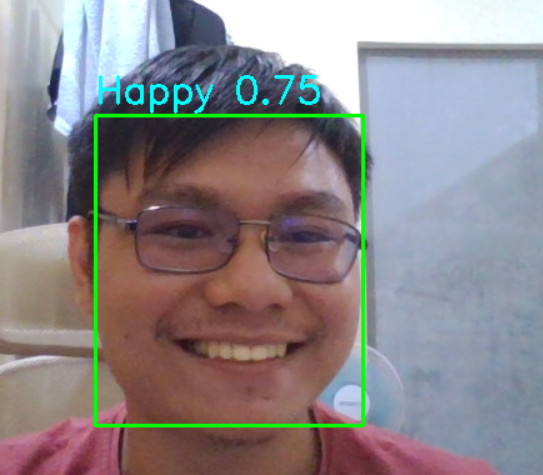

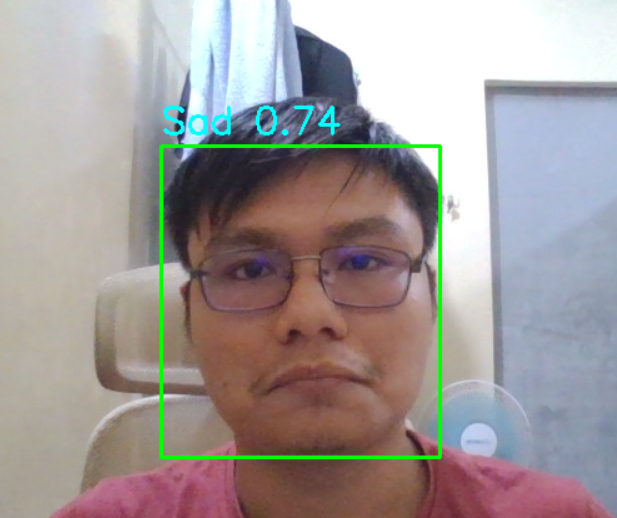

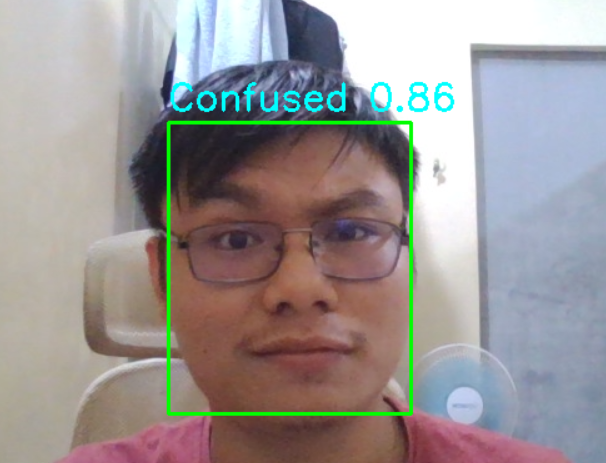

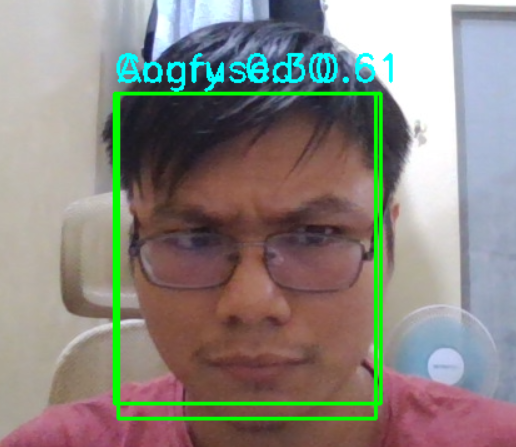

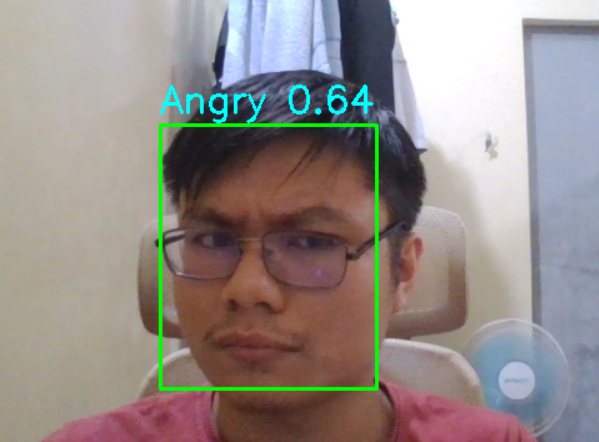

### Evaluation of my mood detection model

Based on the numbers, my model meddles around 60-70% accuracy across all moods which isn't all that great. However, upon opening my video cam to test real world performance, it's predictions are fairly accurate (even though we see a very low confidence score).
It struggles differentiating between angry and confused which is partly my fault because it's hard to distinguish how I expressed it. Their main feature is curled down eyebrows with confused only having one eyebrow elevated. Maybe if I did it differently like opening my mouth, the performance would have been better. Sometimes it isn't the model but the data quality after all.

## Face Identification

### Directory

In [9]:
import os
import shutil
from pathlib import Path
import kagglehub

# === CONFIG ===
base_dir = "face_identity_dataset"
myface_dir = os.path.join(base_dir, "MyFace")
otherface_dir = os.path.join(base_dir, "OtherFace")
mood_dataset = "mood-detection-3/train/images"  # path to mood detection images

# === STEP 1: Create directory structure ===
os.makedirs(myface_dir, exist_ok=True)
os.makedirs(otherface_dir, exist_ok=True)

# === STEP 2: Copy your face images ===
for file in os.listdir(mood_dataset):
    if file.endswith((".jpg", ".jpeg", ".png")):
        src = os.path.join(mood_dataset, file)
        dst = os.path.join(myface_dir, f"myface_{file}")
        shutil.copy(src, dst)

print(f"✅ Copied your face images to {myface_dir}")

# === STEP 3: Download OtherFace dataset from KaggleHub ===
print("⬇️ Downloading LFW dataset from KaggleHub...")
lfw_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("✅ Download complete!")

# === STEP 4: Flatten the OtherFace dataset into our target folder ===
lfw_images_dir = os.path.join(lfw_path, "lfw-dataset", "lfw-deepfunneled")
n_copied = 0
for person_dir in Path(lfw_images_dir).iterdir():
    if person_dir.is_dir():
        for img in person_dir.glob("*.jpg"):
            if n_copied >= 100:  # Limit to 100 other faces for now
                break
            dst = os.path.join(otherface_dir, f"otherface_{n_copied}.jpg")
            shutil.copy(img, dst)
            n_copied += 1

print(f"✅ Copied {n_copied} other face images to {otherface_dir}")


✅ Copied your face images to face_identity_dataset\MyFace
⬇️ Downloading LFW dataset from KaggleHub...


100%|██████████| 112M/112M [00:16<00:00, 7.20MB/s] 

Extracting files...


✅ Download complete!


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\KEN\\.cache\\kagglehub\\datasets\\jessicali9530\\lfw-dataset\\versions\\4\\lfw-dataset\\lfw-deepfunneled'

> Wrong directory mentioned by the previous script, it goes deeper than that. This is the fix.

In [11]:
# === STEP 4: Flatten the OtherFace dataset into our target folder ===
lfw_images_dir = os.path.join(lfw_path, "lfw-deepfunneled", "lfw-deepfunneled")
n_copied = 0
max_images = 334  # limit to 100 images to avoid overfitting

for person_dir in Path(lfw_images_dir).iterdir():
    if person_dir.is_dir():
        for img in person_dir.glob("*.jpg"):
            if n_copied >= max_images:
                break
            dst = os.path.join(otherface_dir, f"otherface_{n_copied}.jpg")
            shutil.copy(img, dst)
            n_copied += 1

print(f"✅ Copied {n_copied} other face images to {otherface_dir}")


✅ Copied 334 other face images to face_identity_dataset\OtherFace


### Let's use a pretrained model to draw Face Bounding Boxes

In [15]:
import os
from ultralytics import YOLO
import cv2

# Load your pretrained face model
model = YOLO("yolov8l_100e.pt")

# Define your folders
base_dir = "face_identity_dataset"
output_dir = os.path.join(base_dir, "yolo_ready")
classes = {"MyFace": 0, "OtherFace": 1}

# Create YOLO-style folder structure
for split in ["train/images", "train/labels"]:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

for cls_name, cls_id in classes.items():
    image_dir = os.path.join(base_dir, cls_name)
    output_img_dir = os.path.join(output_dir, "train/images")
    output_lbl_dir = os.path.join(output_dir, "train/labels")

    for file in os.listdir(image_dir):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        image_path = os.path.join(image_dir, file)
        img = cv2.imread(image_path)
        h, w = img.shape[:2]

        # Run model inference
        results = model(image_path)[0]

        # Save image to YOLO structure
        cv2.imwrite(os.path.join(output_img_dir, file), img)

        # Prepare label file
        label_path = os.path.join(output_lbl_dir, file.rsplit(".", 1)[0] + ".txt")
        with open(label_path, "w") as f:
            for box in results.boxes:
                x1, y1, x2, y2 = box.xyxy[0]
                xc = ((x1 + x2) / 2) / w
                yc = ((y1 + y2) / 2) / h
                bw = (x2 - x1) / w
                bh = (y2 - y1) / h
                f.write(f"{cls_id} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n")

print("✅ Auto-labeling complete and saved in: face_identity_dataset/yolo_ready/")



image 1/1 c:\Users\KEN\Desktop\DSI\Mood Detection Activity\face_identity_dataset\MyFace\myface_angry_0_jpg.rf.16e6ec3a88592f310650f7483ecfb220.jpg: 640x640 1 Face, 86.6ms
Speed: 4.2ms preprocess, 86.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\KEN\Desktop\DSI\Mood Detection Activity\face_identity_dataset\MyFace\myface_angry_0_jpg.rf.2268324d4cd91b20195acb90f6f09645.jpg: 640x640 1 Face, 83.1ms
Speed: 3.4ms preprocess, 83.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\KEN\Desktop\DSI\Mood Detection Activity\face_identity_dataset\MyFace\myface_angry_0_jpg.rf.8934647ed8ad0d6d961ed00267b09c39.jpg: 640x640 1 Face, 24.2ms
Speed: 2.9ms preprocess, 24.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\KEN\Desktop\DSI\Mood Detection Activity\face_identity_dataset\MyFace\myface_angry_10_jpg.rf.e4a1f9a8dbd41c68ecbffe8f2fcaa7a5.jpg: 640x640 1 Face, 24.2ms
Speed: 2.8ms preproc

In [17]:
import os
import random
import shutil
from pathlib import Path

base_dir = "face_identity_dataset/yolo_ready/train"
val_dir = "face_identity_dataset/yolo_ready/val"
os.makedirs(os.path.join(val_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "labels"), exist_ok=True)

# Get all training images
images = list(Path(os.path.join(base_dir, "images")).glob("*.jpg"))
random.shuffle(images)

val_size = int(0.2 * len(images))  # 20% for validation
val_images = images[:val_size]

for img_path in val_images:
    fname = img_path.name
    label_path = Path(base_dir) / "labels" / fname.replace(".jpg", ".txt")

    # Move image
    shutil.move(str(img_path), os.path.join(val_dir, "images", fname))

    # Move label
    if label_path.exists():
        shutil.move(str(label_path), os.path.join(val_dir, "labels", label_path.name))

print(f"✅ Moved {len(val_images)} images and labels to val/")


✅ Moved 133 images and labels to val/


### Training MyFace detector

In [19]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="C:/Users/KEN/Desktop/DSI/Mood Detection Activity/face_identity_dataset/yolo_ready/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    workers=0
)


New https://pypi.org/project/ultralytics/8.3.107 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.75  Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:/Users/KEN/Desktop/DSI/Mood Detection Activity/face_identity_dataset/yolo_ready/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, a

train: Scanning C:\Users\KEN\Desktop\DSI\Mood Detection Activity\face_identity_dataset\yolo_ready\train\labels... 535 images, 0 backgrounds, 0 corrupt: 100%|██████████| 535/535 [00:01<00:00, 473.18it/s]

train: New cache created: C:\Users\KEN\Desktop\DSI\Mood Detection Activity\face_identity_dataset\yolo_ready\train\labels.cache



val: Scanning C:\Users\KEN\Desktop\DSI\Mood Detection Activity\face_identity_dataset\yolo_ready\val\labels... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<00:00, 458.75it/s]

val: New cache created: C:\Users\KEN\Desktop\DSI\Mood Detection Activity\face_identity_dataset\yolo_ready\val\labels.cache
Plotting labels to runs\detect\train5\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.12G       1.02      2.254      1.364         16        640: 100%|██████████| 34/34 [00:11<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        133        152      0.239      0.956      0.752      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.11G     0.6532      1.227      1.043         14        640: 100%|██████████| 34/34 [00:10<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        133        152      0.871      0.772       0.84      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.08G     0.6837      1.132      1.049         17        640: 100%|██████████| 34/34 [00:10<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        133        152      0.891      0.884        0.9      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.08G     0.6609     0.9809      1.032         23        640: 100%|██████████| 34/34 [00:18<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

                   all        133        152      0.907      0.917      0.948      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.08G     0.6279     0.8984      1.007         21        640: 100%|██████████| 34/34 [00:17<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

                   all        133        152       0.89      0.856      0.944      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.1G     0.5779     0.8072      1.002          8        640: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        133        152      0.967      0.922      0.961      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.08G     0.6146     0.7468      1.002          9        640: 100%|██████████| 34/34 [00:11<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]

                   all        133        152      0.972       0.92      0.964      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.08G     0.5785     0.6831     0.9915         18        640: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

                   all        133        152      0.988      0.944      0.966      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.08G     0.5439     0.6509     0.9717         12        640: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]

                   all        133        152      0.981      0.956      0.976      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.08G     0.5329     0.5972     0.9755         13        640: 100%|██████████| 34/34 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.41it/s]

                   all        133        152      0.951      0.944      0.968      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.08G      0.509     0.5398     0.9634         16        640: 100%|██████████| 34/34 [00:09<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]

                   all        133        152      0.989      0.956      0.977      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.08G     0.5329     0.5541     0.9661         21        640: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.45it/s]

                   all        133        152      0.987      0.949      0.971      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.08G     0.5109     0.5272     0.9538         19        640: 100%|██████████| 34/34 [00:09<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.39it/s]

                   all        133        152      0.981      0.967      0.975       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.1G     0.4706     0.4761     0.9492         18        640: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

                   all        133        152      0.997      0.943      0.978      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.08G     0.4952     0.4924     0.9551         10        640: 100%|██████████| 34/34 [00:09<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

                   all        133        152      0.979       0.95      0.977      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.1G     0.5017     0.4883      0.968         17        640: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]

                   all        133        152      0.977      0.969      0.984      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.08G     0.4658     0.4616     0.9446         13        640: 100%|██████████| 34/34 [00:10<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]

                   all        133        152      0.982      0.967      0.979      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.08G     0.4756     0.4542     0.9415         19        640: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all        133        152      0.988       0.96      0.979      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.08G      0.472     0.4504     0.9446         17        640: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.37it/s]

                   all        133        152      0.982      0.949      0.977      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.08G     0.4512     0.4186     0.9319         16        640: 100%|██████████| 34/34 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all        133        152      0.972      0.967      0.979      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.08G     0.4488     0.4147     0.9379         21        640: 100%|██████████| 34/34 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]

                   all        133        152      0.984      0.961      0.986      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.08G      0.413     0.3772     0.9227         26        640: 100%|██████████| 34/34 [00:09<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]

                   all        133        152      0.988      0.967      0.981      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.08G     0.4356     0.4023     0.9342         18        640: 100%|██████████| 34/34 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]

                   all        133        152      0.979      0.978      0.989      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.08G     0.4244     0.3822     0.9371         14        640: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]

                   all        133        152      0.983      0.961      0.987      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.08G      0.441     0.3805     0.9343         17        640: 100%|██████████| 34/34 [00:11<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        133        152      0.983      0.977      0.983      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.08G     0.4233     0.3726     0.9227         12        640: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]

                   all        133        152      0.994      0.967      0.983      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.08G     0.4186     0.3727      0.923         17        640: 100%|██████████| 34/34 [00:18<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]

                   all        133        152      0.997      0.955       0.98      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.08G     0.4136      0.354     0.9248         15        640: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

                   all        133        152       0.99      0.949      0.982      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.1G     0.4023     0.3514     0.9388          7        640: 100%|██████████| 34/34 [00:18<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        133        152      0.977      0.975      0.984      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.08G     0.4078     0.3596     0.9192          8        640: 100%|██████████| 34/34 [00:17<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

                   all        133        152      0.989       0.96       0.98      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.08G     0.4028     0.3398     0.9157         16        640: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

                   all        133        152      0.973      0.971      0.982      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.1G      0.399     0.3341     0.9166         20        640: 100%|██████████| 34/34 [00:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

                   all        133        152      0.996      0.956      0.986      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.1G      0.373     0.3246     0.9115         14        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        133        152      0.994      0.961      0.985      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.08G     0.3646     0.3078     0.9105         16        640: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

                   all        133        152      0.994      0.972      0.987      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.08G     0.3636     0.3064     0.9064         14        640: 100%|██████████| 34/34 [00:17<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        133        152      0.989      0.978      0.985      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.08G     0.3345     0.2857     0.8876         16        640: 100%|██████████| 34/34 [00:18<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

                   all        133        152      0.989      0.978      0.985      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.08G     0.3549      0.295      0.899         20        640: 100%|██████████| 34/34 [00:19<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        133        152       0.99      0.974      0.988      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.08G     0.3378     0.2939     0.8858         14        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

                   all        133        152      0.991      0.961      0.986      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.08G     0.3332     0.2771     0.8968         15        640: 100%|██████████| 34/34 [00:18<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        133        152      0.979      0.971      0.983      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.08G     0.3509     0.2902     0.9038         17        640: 100%|██████████| 34/34 [00:19<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

                   all        133        152       0.99      0.976      0.987      0.961


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.08G     0.2641     0.2507     0.8276          8        640: 100%|██████████| 34/34 [00:17<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        133        152      0.989      0.972      0.988      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.08G     0.2469     0.2324     0.8376          7        640: 100%|██████████| 34/34 [00:17<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        133        152       0.99      0.977      0.989      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.08G     0.2351     0.2185     0.8277          7        640: 100%|██████████| 34/34 [00:17<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

                   all        133        152      0.975      0.972      0.989      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.08G     0.2364     0.2093      0.818          7        640: 100%|██████████| 34/34 [00:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.31it/s]

                   all        133        152      0.991      0.978       0.99      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.08G     0.2418     0.2187     0.8276          8        640: 100%|██████████| 34/34 [00:09<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

                   all        133        152      0.985      0.978       0.99      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.08G     0.2304     0.2065     0.8158         10        640: 100%|██████████| 34/34 [00:09<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]

                   all        133        152      0.983      0.983      0.989      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.08G     0.2204        0.2     0.8266          8        640: 100%|██████████| 34/34 [00:11<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        133        152      0.991      0.977      0.989      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.08G     0.2073     0.1871      0.801          7        640: 100%|██████████| 34/34 [00:18<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

                   all        133        152      0.989      0.982      0.989      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.08G     0.1973     0.1744     0.7987          7        640: 100%|██████████| 34/34 [00:13<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.44it/s]

                   all        133        152      0.995      0.978      0.989      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.08G     0.2075     0.1852     0.8029         12        640: 100%|██████████| 34/34 [00:09<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]

                   all        133        152      0.995       0.98      0.989      0.967



50 epochs completed in 0.225 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 6.2MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics 8.3.75  Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


                   all        133        152      0.995       0.98      0.989      0.967
                MyFace         62         62      0.991          1      0.995      0.995
             OtherFace         71         90          1       0.96      0.983      0.938
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001B78FB22820>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

### Real-Time Testing

In [25]:
import cv2
from ultralytics import YOLO

# Load your trained model
model = YOLO("runs/detect/train5/weights/best.pt")

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLO inference
    results = model(frame)[0]

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls = int(box.cls[0])
        label = model.names[cls]
        conf = float(box.conf[0])

        # Draw bounding box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"{label} {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)

    cv2.imshow("Real-Time Face Identity Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 1 MyFace, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 MyFace, 8.8ms
Speed: 1.2ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 MyFace, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 MyFace, 13.1ms
Speed: 1.2ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 MyFace, 11.0ms
Speed: 1.5ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 MyFace, 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 MyFace, 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 MyFace, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 

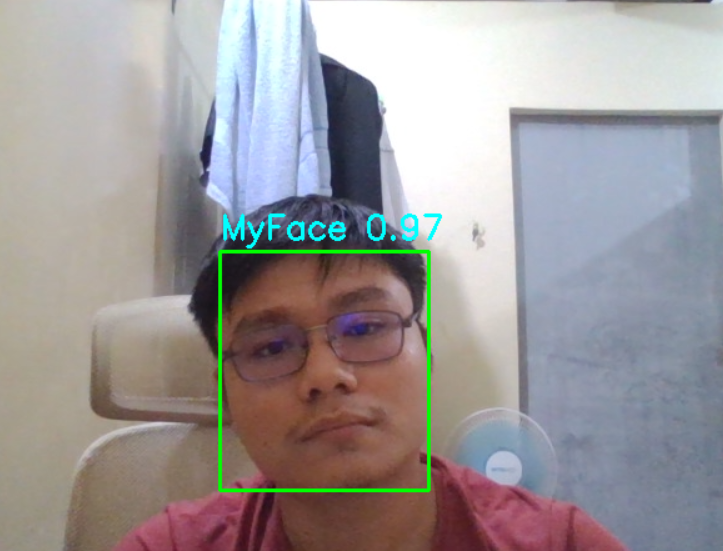

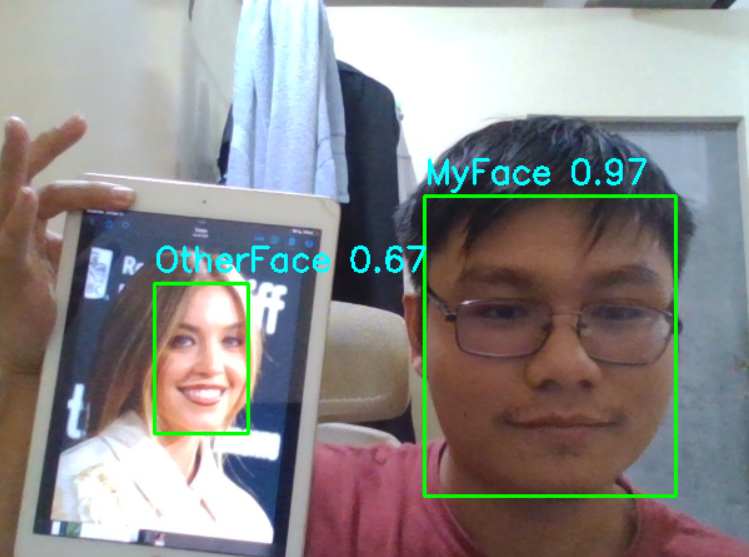

No glasses.

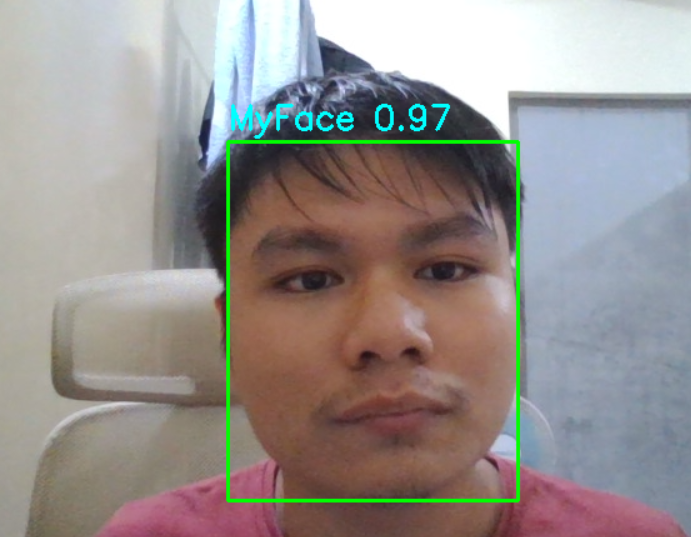

### Evaluation of Face Identification Model

Since this is a binary classification task of the model, we should expect higher results and indeed, it was almost 97% accurate in 

* identifying faces it sees
* classifying whether it's me or not.


### Conclusion

The mood detection activity successfully demonstrated the use of computer vision and deep learning for recognizing human emotions based on facial expressions. By training a YOLOv8 model with annotated images, the system was able to accurately classify moods such as happy, sad, angry, and confused. The project also showcased the effectiveness of real-time inference using a webcam, providing immediate feedback on detected emotions. Overall, the activity deepened understanding of dataset preparation, model training, and the practical application of object detection in emotion recognition.

Most of the challenge was firstly, annotation. It is a tedious task. Second is structuring the directory so the model knows where to pull it's data from. Third is setting up the environment. Thankfully, pytorch is less stricter than tensorflow when supporting GPU acceleration. Now my base environment supports GPU acceleration on bowth Tensorflow and Pytorch.